In [60]:
#import packages
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Concatenate, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, StandardScaler
from numpy.lib.stride_tricks import sliding_window_view
from keras_efficient_kan import KANLinear
import keras
from keras import ops
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Binary classifier model
This section includes the metrics for the binary classifier model

We start by computing the Training and validation datasets

In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras_efficient_kan import KANLinear
from tqdm import tqdm

# ── CONFIG ────────────────────────────────
WEATHER_CSV = "../data/clean/valais_clean.csv"
STATIONS_CSV = "../data/clean/valais_stations.csv"

HIST_LEN = 36     # 6 hours history
HORIZON = 1       # 10 minutes ahead
BATCH_SIZE = 256
EPOCHS = 10
SPLIT_FRACTION = 0.8
LEARNING_RATE = 0.0001

#set the numpy seed to make sure that the unsersampling is reproducible
np.random.seed(42)

# ── LOAD DATA ─────────────────────────────
df_weather = pd.read_csv(WEATHER_CSV)
df_weather["time"] = pd.to_datetime(df_weather["time"], format="%Y%m%d%H%M")

df_stations = pd.read_csv(STATIONS_CSV)
df = df_weather.merge(df_stations[["station", "east", "north", "altitude"]], on="station", how="left")

# ── BUILD WIDE FORMAT ─────────────────────
selected_features = ['precip', 'temperature', 'East', 'North', 'pressure', 'moisture']
metadata_features = ['east', 'north', 'altitude']

all_features = selected_features + metadata_features

df_features = df[["time", "station"] + all_features].copy()
df_pivot = df_features.pivot(index="time", columns="station", values=all_features)
df_pivot.columns = [f"{feat}_{station}" for feat, station in df_pivot.columns]
df_pivot = df_pivot.sort_index()
df_pivot = df_pivot.dropna()  


# ── SPLITTING ───────────────────────────────
split1 = int(0.6 * len(df_pivot))
split2 = int(0.8 * len(df_pivot))
df_train = df_pivot.iloc[:split1]
df_test  = df_pivot.iloc[split2:]

# ── SCALING ───────────────────────────────
scaler = StandardScaler()
data_train = scaler.fit_transform(df_train)
data_test  = scaler.transform(df_test)

# ── SAMPLE CONSTRUCTION ───────────────────
# ── SETUP ──────────────────────────────────
precip_cols = [col for col in df_pivot.columns if col.startswith("precip_")]
num_stations = len(precip_cols)

# ── TEST SET CONSTRUCTION (no undersampling) ─
x_test, y_test = [], []
test_scaled = pd.DataFrame(data_test, columns=df_test.columns, index=df_test.index)

for i in range(HIST_LEN, len(test_scaled) - HORIZON):
    x_window = test_scaled.iloc[i - HIST_LEN:i].values
    horizon_vals = df_test.iloc[i + 1 : i + 1 + HORIZON][precip_cols].values
    y_window = (np.any(horizon_vals > 0, axis=0)).astype(int)

    x_test.append(x_window)
    y_test.append(y_window)

# ── CONVERT TO ARRAYS ─────────────────────
x_test  = np.array(x_test)
y_test  = np.array(y_test)

Now we load the model

In [63]:
model_binary = keras.models.load_model('../model_testing/forecast_binary_1.keras')

We compute the test metrics

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Predict
y_pred_proba = model_binary.predict(x_test)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Flatten all stations across all samples
y_true_flat = y_test.flatten()
y_pred_flat = y_pred_binary.flatten()
y_proba_flat = y_pred_proba.flatten()

# Compute metrics
acc  = accuracy_score(y_true_flat, y_pred_flat)
prec = precision_score(y_true_flat, y_pred_flat)
rec  = recall_score(y_true_flat, y_pred_flat)
f1   = f1_score(y_true_flat, y_pred_flat)
auc  = roc_auc_score(y_true_flat, y_proba_flat)

# Print LaTeX table
print(f'ACC:{acc}, PREcision:{prec}, Recall:{rec}, f1:{f1}, auc:{auc}')


1643/1643 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step
ACC:0.9522952662759425, PREcision:0.7213578322150617, Recall:0.5999978999758497, f1:0.6551047139176218, auc:0.9622234733175976


The roc curve and AUC

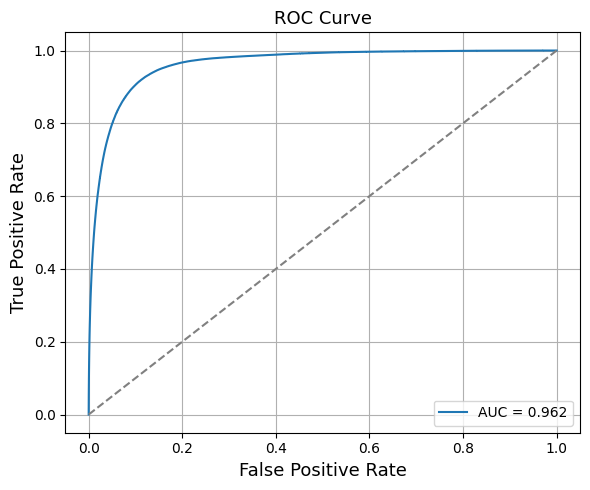

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_flat, y_proba_flat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.title("ROC Curve", fontsize=13)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig('../report/figures/model_summary/ROC_curve_minutes.pdf')
plt.show()

and a confusion matrix

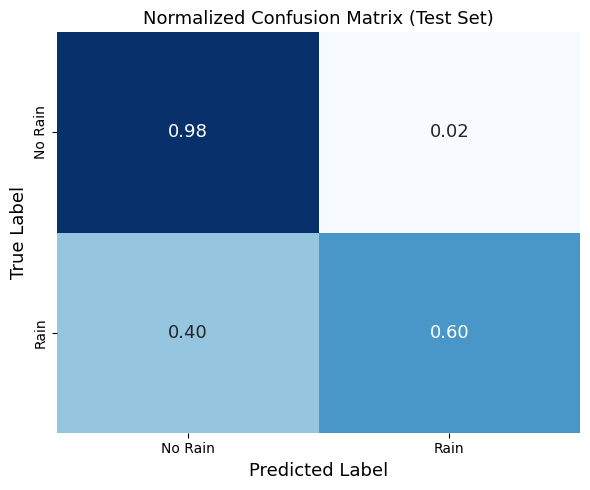

In [66]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_flat, y_pred_flat, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            annot_kws={"fontsize": 13},
            xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("True Label", fontsize=13)
plt.title("Normalized Confusion Matrix (Test Set)", fontsize=13)
plt.tight_layout()
plt.savefig('../report/figures/model_summary/conf_matrix_binary_minutes.pdf')
plt.show()

Lets visualize a variable importance plot

In [ ]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Flatten input for variable-level importances (last timestep only)
X_last_step = x_test[:, -1, :]  # shape = (samples, features)
y_binary = y_test.flatten()     # binary labels (flatten if needed)

# Predict with custom wrapper
def predict_fn(X):
    X_seq = np.tile(X[:, np.newaxis, :], (1, x_test.shape[1], 1))  # repeat along time axis
    return model_binary.predict(X_seq).flatten()

# Run permutation importance
result = permutation_importance(
    estimator=model_binary,
    X=X_last_step,
    y=y_binary,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42
)

# Sort and plot
feature_names = ['precip', 'temperature', 'East', 'North', 'pressure', 'moisture', 'east', 'north', 'altitude']
sorted_idx = np.argsort(result.importances_mean)[::-1]

plt.figure(figsize=(8, 6))
plt.barh(np.array(feature_names)[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Mean decrease in AUC")
plt.title("Permutation Feature Importance (Last Step Only)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Next, we create maps of the probabilities

In [67]:
import pandas as pd
import numpy as np
import os
import gstools as gs
from tqdm.contrib.concurrent import process_map
import rasterio
import matplotlib.pyplot as plt

c:\Users\elwin\Desktop\MeteoThesis\neuralforecast\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
import gstools as gs  # gstools
from keras.models import load_model
from sklearn.preprocessing import StandardScaler

# ── CONFIG ────────────────────────────────
STATIONS_CSV = "../data/clean/valais_stations.csv"
ELEVATION_ASC = "../data/clean/valais_elevation.asc"

# ── LOAD STATION LOCATIONS ───────────────
df_stations = pd.read_csv(STATIONS_CSV)
df_stations['east'] = df_stations['east'] + 2000000
df_stations['north'] = df_stations['north'] + 1000000

# ── LOAD STATION LOCATIONS ───────────────
df_daily = pd.read_csv('../data/clean/daily_data.csv')
stations_kept = df_daily['unique_id'].unique()


df_stations = df_stations[df_stations['station'].isin(stations_kept)]

# Step 1: Predict all values at once
predicted_probs_all = model_binary.predict(x_test)  # shape: (num_samples, num_stations)

# Step 2: Select a sample with avg predicted rain prob > 0.5
threshold = 0.5
selected_idx = None

for i in range(len(predicted_probs_all)):
    if np.mean(predicted_probs_all[i]) > threshold:
        selected_idx = i
        break

# Step 3: Extract corresponding data
if selected_idx is not None:
    x_sample = x_test[selected_idx:selected_idx+1]
    y_sample = y_test[selected_idx]
    predicted_sample = predicted_probs_all[selected_idx]
    print(f"Selected index {selected_idx} with avg predicted prob = {np.mean(predicted_sample):.2f}")
else:
    print("No sample found with predicted avg rain > 0.5")




1643/1643 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step
Selected index 1055 with avg predicted prob = 0.58


In [69]:
# ── PREDICT RAIN PROBABILITIES ────────────
predicted_probs = model_binary.predict(x_sample)[0]  # shape: (num_stations,)
df_stations["rain_prob"] = predicted_sample

# ── INTERPOLATION ─────────────────────────
def ked_interpolation_gstools(known_points, unknown_points):
    x_known, y_known, z_known = known_points[:, 0], known_points[:, 1], known_points[:, 2]
    values = known_points[:, 3]
    x_unknown, y_unknown, z_unknown = unknown_points[:, 0], unknown_points[:, 1], unknown_points[:, 2]

    if np.all(values == 0):
        return np.zeros(len(unknown_points))

    bin_center, gamma = gs.vario_estimate((x_known, y_known), values, bin_edges=np.linspace(0, 100000, 15))
    model = gs.Exponential(dim=2)
    model.fit_variogram(bin_center, gamma)

    ked = gs.krige.ExtDrift(model=model, cond_pos=(x_known, y_known), cond_val=values, ext_drift=z_known)
    predictions, _ = ked((x_unknown, y_unknown), ext_drift=z_unknown, return_var=True)
    return predictions

known_points = df_stations[["east", "north", "altitude", "rain_prob"]].values

with rasterio.open(ELEVATION_ASC) as src:
    elevation_grid = src.read(1)
    transform = src.transform
    bounds = src.bounds
    height, width = elevation_grid.shape
    rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)

    unknown_points = np.column_stack([
        xs.flatten(),
        ys.flatten(),
        elevation_grid.flatten()
    ])

# Interpolate
mask_valid = ~np.isnan(unknown_points[:, 2])
interpolated_values = np.full(len(unknown_points), np.nan)
interpolated_values[mask_valid] = ked_interpolation_gstools(known_points, unknown_points[mask_valid])

# Reshape for plotting
full_grid = interpolated_values.reshape(elevation_grid.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


plot the interpolated values

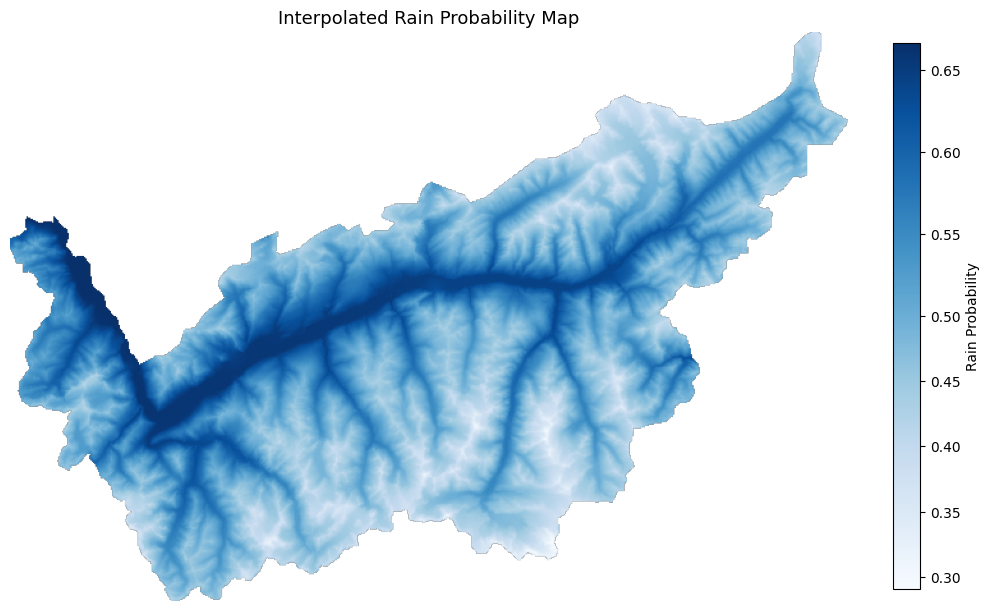

In [70]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from matplotlib.colors import TwoSlopeNorm

# Determine min and max from your data
vmin = np.nanmin(full_grid)
vmax = np.nanmax(full_grid)
vcenter = 0.5

# Create a normalization centered at 0.5
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(
    full_grid,
    cmap='Blues',
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
    origin='upper',
    norm=norm
)
ax.set_axis_off()
plt.colorbar(img, ax=ax, label="Rain Probability", fraction=0.03)
plt.title(f"Interpolated Rain Probability Map", fontsize=13)
plt.tight_layout()
plt.savefig('../report/figures/model_summary/rain_probs_full_map_minutes.pdf')
plt.show()

Let's add a background to the map, and color only if it is above 0.5

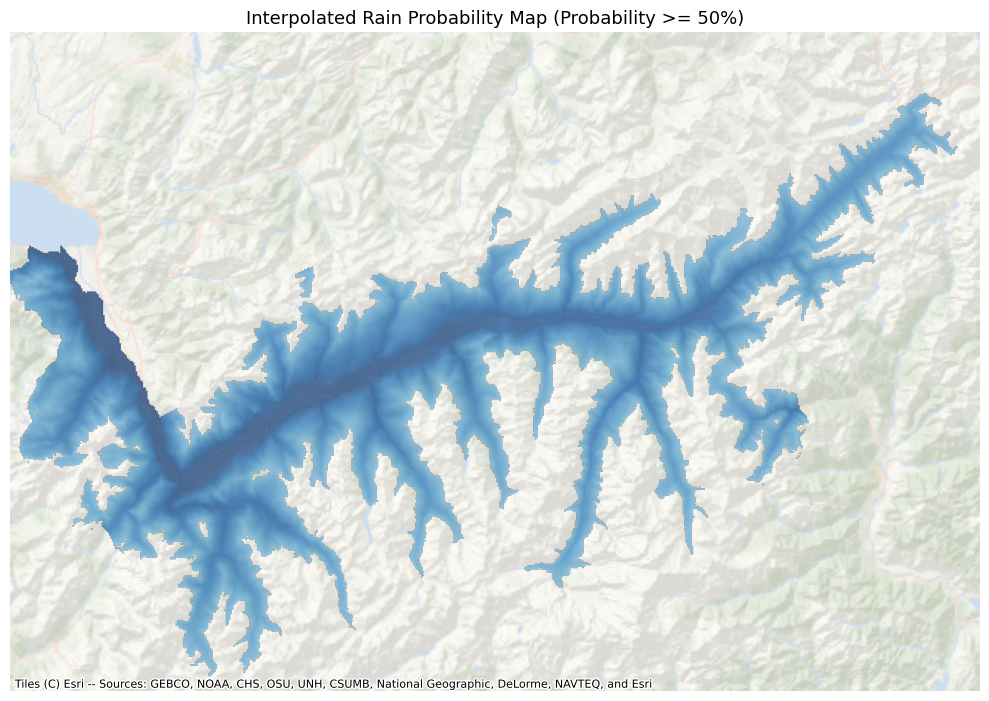

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import contextily as cx
import xyzservices.providers as xyz
import numpy.ma as ma

# Mask values under 50%
masked_grid = ma.masked_less(full_grid, 0.5)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the masked interpolated rain probability map with transparency
img = ax.imshow(
    masked_grid,
    cmap='Blues',
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
    origin='upper',
    alpha=0.7,
    zorder=3,
    norm=norm 
)

# Add basemap behind
cx.add_basemap(
    ax,
    source=xyz.Esri.OceanBasemap,
    crs="EPSG:2056"
)

# Finalize
ax.set_axis_off()
plt.title(f"Interpolated Rain Probability Map (Probability >= 50%)", fontsize=13)
plt.tight_layout()
plt.savefig('../report/figures/model_summary/rain_prob_map_minutes.pdf')
plt.show()

In [88]:
import contextily as cx
import rasterio
from rasterio.plot import show

# Output raster path
basemap_tif = "../data/raw/valais_national_map.tif"

# Save the raster
cx.bounds2raster(
    bounds.left, bounds.bottom, bounds.right, bounds.top,
    zoom=12,  # adjust for detail (higher = sharper & slower)
    source=xyz.SwissFederalGeoportal.NationalMapGrey,
    ll=False,
    path=basemap_tif
)

HTTPError: Connection reset by peer too many times. Last message was: 400 Error: Bad Request for url: https://wmts.geo.admin.ch/1.0.0/ch.swisstopo.pixelkarte-grau/default/current/3857/12/2308/1928.jpeg

# Scraps

In [17]:
WEATHER_CSV = "../data/clean/valais_clean.csv"
STATIONS_CSV = "../data/clean/valais_stations.csv"

HIST_LEN = 36      # 6 hours history @ 10-minute freq
HORIZON = 1        # predict 1 hour ahead (6 * 10 minutes)
BATCH_SIZE = 256
EPOCHS = 10
SPLIT_FRACTION = 0.8
LEARNING_RATE = 0.001

# ── LOAD & PREP DATA ─────────────────────────────
df_weather = pd.read_csv(WEATHER_CSV)
df_weather["time"] = pd.to_datetime(df_weather["time"], format="%Y%m%d%H%M")

df_stations = pd.read_csv(STATIONS_CSV)
df = df_weather.merge(df_stations[["station", "east", "north", "altitude"]], on="station", how="left")
df = df[df["station"] == "SIO"]

# ── NORMALIZE ────────────────────────────────────
selected_features = ['precip', 'temperature', 'East', 'North', 'pressure', 'moisture']
features = df[selected_features]
features.index = df["time"]

train_split = int(SPLIT_FRACTION * len(features))
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features = pd.DataFrame(features_scaled, index=features.index, columns=selected_features)

x = []
y = []

# ── CREATE SAMPLES ───────────────────────────────
for i in range(HIST_LEN, len(features) - HORIZON):
    x.append(features.iloc[i - HIST_LEN:i].values)
    y.append(features.iloc[i + HORIZON]["precip"])  # forecast rain

x = np.array(x)
y = np.array(y)

split_idx = int(SPLIT_FRACTION * len(x))
x_train, x_val = x[:split_idx], x[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

In [21]:
model_one =  keras.models.load_model("../model_testing/forecast_lstm__kan_balanced.keras")

1644/1644 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step
✅ RMSE  : 1.1790
✅ MSE   : 1.3901
✅ MAE   : 0.2884
✅ R²    : 0.1654


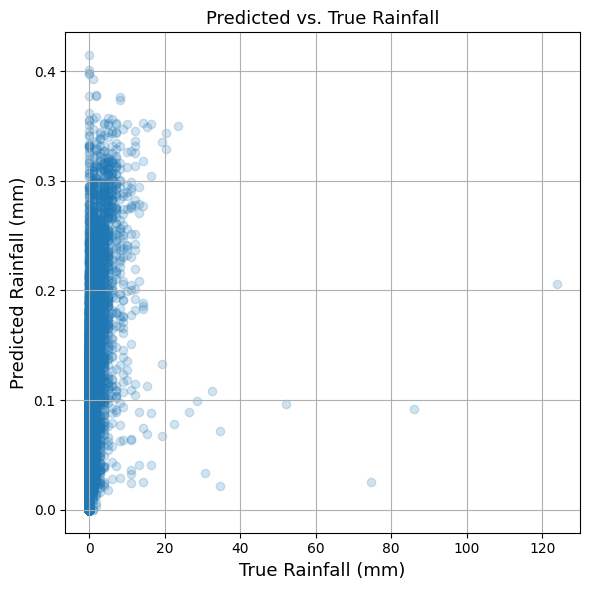

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# De-log the predictions and targets
y_pred = model_one.predict(x_val)
y_true = y_val

# Flatten to compute global metrics across all stations
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# Compute metrics
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_flat, y_pred_flat)
correlation = np.corrcoef(y_true_flat, y_pred_flat)[0, 1]
r2 = correlation ** 2

# Print results
print(f"✅ RMSE  : {rmse:.4f}")
print(f"✅ MSE   : {mse:.4f}")
print(f"✅ MAE   : {mae:.4f}")
print(f"✅ R²    : {r2:.4f}")




import matplotlib.pyplot as plt

y_pred_flat_clip = np.clip(y_pred_flat, 0, None)

plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat, y_pred_flat_clip, alpha=0.2)
plt.xlabel("True Rainfall (mm)", fontsize=13)
plt.ylabel("Predicted Rainfall (mm)", fontsize=13)
plt.title("Predicted vs. True Rainfall", fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.savefig('../report/figures/model_summary/scatter_pred_true.png', dpi=60)
plt.show()

In [ ]:
# ── DEFINE THRESHOLD ──────────────────────────────────────
RAIN_THRESHOLD = 0.1

# ── CONVERT TO BINARY CLASSES ─────────────────────────────
y_true_binary = (y_val >= RAIN_THRESHOLD).astype(int)
y_pred_binary = (y_pred >= RAIN_THRESHOLD).astype(int)

# ── CONFUSION MATRIX ──────────────────────────────────────
cm = confusion_matrix(y_true_binary, y_pred_binary, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Rain", "Rain"])

disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Predicted vs Actual Rain")
plt.grid(False)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras_efficient_kan import KANLinear
from tqdm import tqdm

# ── CONFIG ────────────────────────────────
WEATHER_CSV = "../data/clean/valais_clean.csv"
STATIONS_CSV = "../data/clean/valais_stations.csv"

HIST_LEN = 36     # 6 hours history
HORIZON = 6       # 1 hour ahead
BATCH_SIZE = 256
EPOCHS = 10
SPLIT_FRACTION = 0.8
LEARNING_RATE = 0.0001

# ── LOAD DATA ─────────────────────────────
df_weather = pd.read_csv(WEATHER_CSV)
df_weather["time"] = pd.to_datetime(df_weather["time"], format="%Y%m%d%H%M")

df_stations = pd.read_csv(STATIONS_CSV)
df = df_weather.merge(df_stations[["station", "east", "north", "altitude"]], on="station", how="left")

# ── BUILD WIDE FORMAT ─────────────────────
selected_features = ['precip', 'temperature', 'East', 'North', 'pressure', 'moisture']
metadata_features = ['east', 'north', 'altitude']

all_features = selected_features + metadata_features

df_features = df[["time", "station"] + all_features].copy()
df_pivot = df_features.pivot(index="time", columns="station", values=all_features)
df_pivot.columns = [f"{feat}_{station}" for feat, station in df_pivot.columns]
df_pivot = df_pivot.sort_index()
df_pivot = df_pivot.dropna()  

# ── SCALING ───────────────────────────────
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_pivot)
data_scaled = pd.DataFrame(data_scaled, columns=df_pivot.columns, index=df_pivot.index)

# ── SAMPLE CONSTRUCTION ───────────────────
x, y = [], []

precip_cols = [col for col in df_pivot.columns if col.startswith("precip_")]
num_stations = len(precip_cols)

for i in range(HIST_LEN, len(data_scaled) - HORIZON):
    x_window = data_scaled.iloc[i - HIST_LEN:i].values
    y_window = df_pivot.iloc[i + HORIZON][precip_cols].values  # unscaled precip for all stations

    total_future_rain = np.sum(y_window)

    # Optional undersampling
    if total_future_rain == 0 and np.random.rand() > 0.1:
        continue

    x.append(x_window)
    y.append(y_window)

x = np.array(x)  
y = np.array(y)  
y = np.log1p(y)  

# ── SPLIT ─────────────────────────────────
split_idx = int(SPLIT_FRACTION * len(x))
x_train, x_val = x[:split_idx], x[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

In [ ]:
model2 = keras.models.load_model("../model_testing/forecast_allstation_lstm_kan.keras")

# One-step-ahead forecast
start by getting the data inplace

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras_efficient_kan import KANLinear
from tqdm import tqdm

# ── CONFIG ────────────────────────────────
WEATHER_CSV = "../data/clean/valais_clean.csv"
STATIONS_CSV = "../data/clean/valais_stations.csv"

HIST_LEN = 36     # 6 hours history
HORIZON = 6       # 1 hour ahead
BATCH_SIZE = 256
EPOCHS = 10
SPLIT_FRACTION = 0.8
LEARNING_RATE = 0.0001

# ── LOAD DATA ─────────────────────────────
df_weather = pd.read_csv(WEATHER_CSV)
df_weather["time"] = pd.to_datetime(df_weather["time"])

df_stations = pd.read_csv(STATIONS_CSV)
df = df_weather.merge(df_stations[["station", "east", "north", "altitude"]], on="station", how="left")

# ── BUILD WIDE FORMAT ─────────────────────
selected_features = ['precip', 'temperature', 'East', 'North', 'pressure', 'moisture']
metadata_features = ['east', 'north', 'altitude']

all_features = selected_features + metadata_features

df_features = df[["time", "station"] + all_features].copy()
df_pivot = df_features.pivot(index="time", columns="station", values=all_features)
df_pivot.columns = [f"{feat}_{station}" for feat, station in df_pivot.columns]
df_pivot = df_pivot.sort_index()
df_pivot = df_pivot.dropna()  


# ── SPLITTING RAW TIME INDEX ─────────────────────────
split1 = int(0.6 * len(df_pivot))  # train
split2 = int(0.8 * len(df_pivot))  # val
df_train = df_pivot.iloc[:split1]
df_val   = df_pivot.iloc[split1:split2]
df_test  = df_pivot.iloc[split2:]

# ── SCALING ──────────────────────────────────────────
scaler = StandardScaler()
data_train = scaler.fit_transform(df_train)
data_val   = scaler.transform(df_val)
data_test  = scaler.transform(df_test)

data_train = pd.DataFrame(data_train, columns=df_train.columns, index=df_train.index)
data_val   = pd.DataFrame(data_val,   columns=df_val.columns,   index=df_val.index)
data_test  = pd.DataFrame(data_test,  columns=df_test.columns,  index=df_test.index)

# ── PRECIP COLUMNS ──────────────────────────────────
precip_cols = [col for col in df_pivot.columns if col.startswith("precip_")]
num_stations = len(precip_cols)
x_train, y_train = [], []

for i in range(HIST_LEN, len(data_train) - HORIZON):
    x_window = data_train.iloc[i - HIST_LEN:i].values
    y_window = df_train.iloc[i+HORIZON][precip_cols].values  # unscaled

    total_future_rain = np.sum(y_window)

    if total_future_rain == 0 and np.random.rand() > 0.1:
        continue

    x_train.append(x_window)
    y_train.append(y_window)

x_train = np.array(x_train)
y_train = np.array(y_train)

x_val, y_val = [], []
for i in range(HIST_LEN, len(data_val) - HORIZON):
    x_window = data_val.iloc[i - HIST_LEN:i].values
    y_window = df_val.iloc[i + HORIZON][precip_cols].values
    x_val.append(x_window)
    y_val.append(y_window)

x_val = np.array(x_val)
y_val = np.array(y_val)

x_test, y_test = [], []
for i in range(HIST_LEN, len(data_test) - HORIZON):
    x_window = data_test.iloc[i - HIST_LEN:i].values
    y_window = df_test.iloc[i + HORIZON][precip_cols].values
    x_test.append(x_window)
    y_test.append(y_window)

x_test = np.array(x_test)
y_test = np.array(y_test) 

Now we load the model

In [8]:
model_hourly = keras.models.load_model('../model_testing/final_one_step_fcst_hourly.keras')

We compute various metrics (MSE, MAE, RMSE, R-squared)

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# De-log the predictions and targets
y_pred = model_hourly.predict(x_test)
y_true = y_test

# Flatten to compute global metrics across all stations
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# Compute metrics
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_flat, y_pred_flat)
correlation = np.corrcoef(y_true_flat, y_pred_flat)[0, 1]
r2 = correlation ** 2

# Print results
print(f"✅ RMSE  : {rmse:.4f}")
print(f"✅ MSE   : {mse:.4f}")
print(f"✅ MAE   : {mae:.4f}")
print(f"✅ R²    : {r2:.4f}")


273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
✅ RMSE  : 0.5789
✅ MSE   : 0.3351
✅ MAE   : 0.2000
✅ R²    : 0.0054


In [ ]:
from pyextremes import plot_mean_residual_life

plot_mean_residual_life(df_weather['precip'])


to ensure quality, we can also compute a scatter plot of the predicted vs actual values

In [ ]:
import matplotlib.pyplot as plt

y_pred_flat_clip = np.clip(y_pred_flat, 0, None)

plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat, y_pred_flat_clip, alpha=0.2)
plt.xlabel("True Rainfall (mm)", fontsize=13)
plt.ylabel("Predicted Rainfall (mm)", fontsize=13)
plt.title("Predicted vs. True Rainfall", fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.savefig('../report/figures/model_summary/scatter_pred_true.png', dpi=60)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume predictions are clipped/log-corrected
y_true_rain = np.expm1(y_test).flatten()
y_pred_rain = np.expm1(model_onestep.predict(x_test)).flatten()
y_pred_rain = np.clip(y_pred_rain, 0, None)

# Binarize: 1 = rain, 0 = no rain
threshold = 0.1
y_true_bin = (y_true_rain > threshold).astype(int)
y_pred_bin = (y_pred_rain > threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true_bin, y_pred_bin, normalize='true')

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=["No Rain", "Rain"],
            yticklabels=["No Rain", "Rain"],
            annot_kws={"fontsize": 13})
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("True Label", fontsize=13)
plt.title("Confusion Matrix (Rain Threshold = 0.1mm)", fontsize=13)
plt.tight_layout()
plt.savefig('../report/figures/model_summary/confusion_matrix_thres.pdf')
plt.show()

In [ ]:
np.percentile(y_train, np.arange(101))


And we visualize some forecasts

In [ ]:
import random

# Re-log targets for easier work
y_true_full = np.expm1(y_test)
y_pred_full = np.expm1(model_onestep.predict(x_test))

# Get 6-hour totals per prediction (row-wise sum over stations)
total_rain_6hr = np.sum(y_true_full, axis=1)

# 1. Well-forecasted rainy sample (true > 0 and small error)
rainy_idxs = np.where(total_rain_6hr > 0)[0]
well_predicted = [i for i in rainy_idxs if np.allclose(y_true_full[i], y_pred_full[i], atol=1.0)]
idx_good = random.choice(well_predicted)

# 2. Extreme rain sample (top 10 max total rain)
idx_extreme = np.argsort(total_rain_6hr)[-10:]
idx_bad = idx_extreme[-1]

def plot_sample(idx, title):
    plt.figure(figsize=(10, 4))
    for station in range(y_true.shape[1]):
        plt.plot(x_test[idx, :, station], label=f"Station {station}", alpha=0.5)
    plt.title(f"{title} — Input (past values)")
    plt.xlabel("Time step")
    plt.ylabel("Scaled feature value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(y_true_full[idx], label="True", marker='o')
    plt.plot(y_pred_full[idx], label="Predicted", marker='x')
    plt.title(f"{title} — One-Step Forecast (per station)")
    plt.xlabel("Station")
    plt.ylabel("Rainfall (mm)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot both
plot_sample(idx_good, "Good Rain Forecast Example")
plot_sample(idx_bad, "Extreme Rain Forecast Example (High Error Expected)")


# Long format only rain events

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras_efficient_kan import KANLinear

# ── CONFIG ────────────────────────────────
WEATHER_CSV = "../data/clean/valais_clean.csv"
STATIONS_CSV = "../data/clean/valais_stations.csv"
HIST_LEN = 36
HORIZON = 1
BATCH_SIZE = 256
EPOCHS = 10
LEARNING_RATE = 0.0001

# ── LOAD DATA ─────────────────────────────
df_weather = pd.read_csv(WEATHER_CSV)
df_weather["time"] = pd.to_datetime(df_weather["time"], format="%Y%m%d%H%M")
df_stations = pd.read_csv(STATIONS_CSV)
df = df_weather.merge(df_stations[["station", "east", "north", "altitude"]], on="station", how="left")

# ── ENCODE STATIONS ───────────────────────
le = LabelEncoder()
df["station_id"] = le.fit_transform(df["station"])
num_stations = len(le.classes_)

# ── FEATURE ENGINEERING ────────────────────
selected_features = ['precip', 'temperature', 'east', 'north', 'pressure', 'moisture']
metadata_features = ['east', 'north', 'altitude']
all_features = selected_features + metadata_features

# ── TIME SPLIT ─────────────────────────────
time_sorted = df["time"].sort_values().unique()
split1 = int(0.6 * len(time_sorted))
split2 = int(0.8 * len(time_sorted))
train_times = time_sorted[:split1]
val_times = time_sorted[split1:split2]
test_times = time_sorted[split2:]

df_train = df[df["time"].isin(train_times)].copy()
df_val = df[df["time"].isin(val_times)].copy()
df_test = df[df["time"].isin(test_times)].copy()

# ── SCALE ONLY ON TRAIN ────────────────────
scaler = StandardScaler()
df_train[all_features] = scaler.fit_transform(df_train[all_features])
df_val[all_features] = scaler.transform(df_val[all_features])
df_test[all_features] = scaler.transform(df_test[all_features])

# ── DROP ANY NaNs AFTER SCALING ────────────
df_train.dropna(inplace=True)
df_val.dropna(inplace=True)
df_test.dropna(inplace=True)

# ── BUILD SAMPLES (RAIN ONLY) ──────────────
def construct_samples(df_input):
    x, y, stations = [], [], []
    full_df = df_input.sort_values("time")
    for station, group in full_df.groupby("station"):
        sid = group["station_id"].iloc[0]
        group = group.sort_values("time")
        features = group[all_features].values
        target = group["precip"].values

        for i in range(HIST_LEN, len(group) - HORIZON):
            x_window = features[i - HIST_LEN:i]
            y_val = target[i + HORIZON]

            if y_val <= 0:
                continue

            x.append(x_window)
            y.append(np.log1p(y_val))
            stations.append(sid)

    return np.array(x), np.array(y), np.array(stations)

x_train, y_train, station_train = construct_samples(df_train)
x_val, y_val, station_val = construct_samples(df_val)
x_test, y_test, station_test = construct_samples(df_test)

In [ ]:
model_long = keras.models.load_model('../model_testing/final_one_step_fcst_long.keras')

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# De-log the predictions and targets
y_pred = model_long.predict([x_test, station_test])
y_true = y_test

# Flatten to compute global metrics across all stations
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# Compute metrics
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_flat, y_pred_flat)
correlation = np.corrcoef(y_true_flat, y_pred_flat)[0, 1]
r2 = correlation ** 2

# Print results
print(f"✅ RMSE  : {rmse:.4f}")
print(f"✅ MSE   : {mse:.4f}")
print(f"✅ MAE   : {mae:.4f}")
print(f"✅ R²    : {r2:.4f}")

5953/5953 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step
✅ RMSE  : 0.4403
✅ MSE   : 0.1939
✅ MAE   : 0.3373
✅ R²    : 0.3379


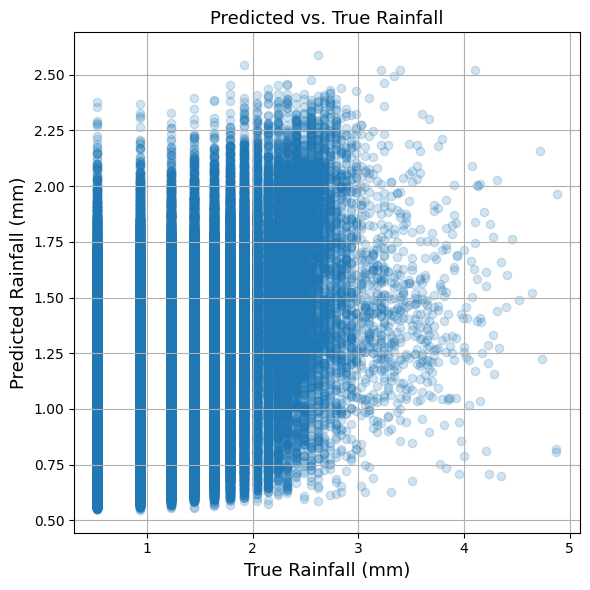

In [ ]:
import matplotlib.pyplot as plt

y_pred_flat_clip = np.clip(y_pred_flat, 0, None)

plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat, y_pred_flat_clip, alpha=0.2)

plt.xlabel("True Rainfall (mm)", fontsize=13)
plt.ylabel("Predicted Rainfall (mm)", fontsize=13)
plt.title("Predicted vs. True Rainfall", fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.savefig('../report/figures/model_summary/scatter_pred_true.png', dpi=60)
plt.show()

# Wide per station forecasts

In [77]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras_efficient_kan import KANLinear

# ── CONFIG ────────────────────────────────
WEATHER_CSV = "../data/clean/valais_clean.csv"
STATIONS_CSV = "../data/clean/valais_stations.csv"
HIST_LEN = 36
HORIZON = 1
BATCH_SIZE = 256
EPOCHS = 10
LEARNING_RATE = 0.0001

# ── LOAD DATA ─────────────────────────────
df_weather = pd.read_csv(WEATHER_CSV)
df_weather["time"] = pd.to_datetime(df_weather["time"], format="%Y%m%d%H%M")
df_stations = pd.read_csv(STATIONS_CSV)
df = df_weather.merge(df_stations[["station", "east", "north", "altitude"]], on="station", how="left")

# ── FEATURE ENGINEERING ────────────────────
selected_features = ['precip', 'temperature', 'East', 'North', 'pressure', 'moisture']
metadata_features = ['east', 'north', 'altitude']

all_features = selected_features + metadata_features
# ── PIVOT TO WIDE FORMAT ───────────────────
df_pivot = df.pivot(index='time', columns='station', values=all_features)
df_pivot.columns = [f"{feat}_{station}" for feat, station in df_pivot.columns]
df_pivot.sort_index(inplace=True)
df_pivot.dropna(inplace=True)

# ── SPLIT BY TIME ──────────────────────────
split1 = int(0.6 * len(df_pivot))
split2 = int(0.8 * len(df_pivot))
df_train = df_pivot.iloc[:split1]
df_test = df_pivot.iloc[split2:]

# ── SCALE FEATURES ─────────────────────────
scaler = StandardScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns, index=df_train.index)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns, index=df_test.index)

# ── BUILD SAMPLES ──────────────────────────
def build_samples(df_src, df_target, station_list):
    x, y = [], []
    for station in station_list:
        col_name = f"precip_{station}"
        for i in range(HIST_LEN, len(df_src) - HORIZON):
            y_val = df_target.iloc[i + HORIZON][col_name]
            if y_val <= 0:
                continue
            x_window = df_src.iloc[i - HIST_LEN:i].values
            x.append(x_window)
            y.append(np.log1p(y_val))
    return np.array(x), np.array(y)

station_list = df["station"].unique()
x_test, y_test = build_samples(df_test_scaled, df_test, station_list)

In [78]:
import keras
model_wide = keras.models.load_model("../model_testing/final_one_step_fcst_wide.keras")

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# De-log the predictions and targets
y_pred = model_wide.predict(x_test)
y_true = y_test

# Compute metrics
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_flat, y_pred_flat)
correlation = np.corrcoef(y_true_flat, y_pred_flat)[0, 1]
r2 = correlation ** 2

# Print results
print(f"✅ RMSE  : {rmse:.4f}")
print(f"✅ MSE   : {mse:.4f}")
print(f"✅ MAE   : {mae:.4f}")
print(f"✅ R²    : {r2:.4f}")

5953/5953 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step


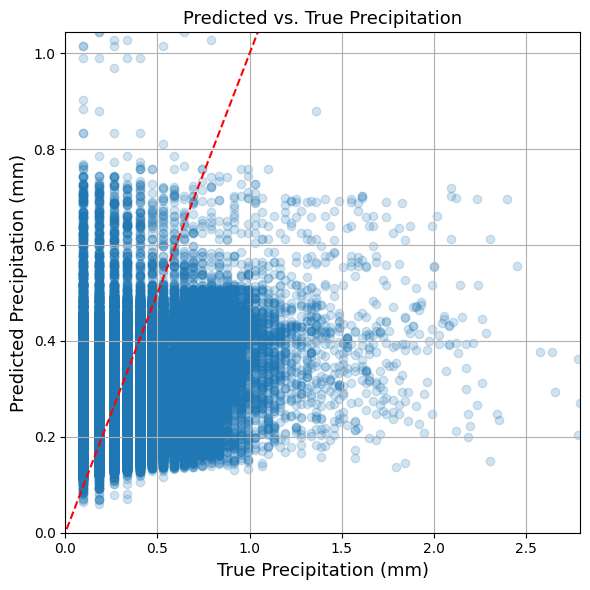

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten to compute global metrics across all stations
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# Assume y_true_flat and y_pred_flat_clip are already defined
y_pred_flat_clip = np.clip(y_pred_flat, 0, None)
y_one = [-1, 0,1,2]

plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat, y_pred_flat_clip, alpha=0.2)

plt.plot(y_one, y_one, 'r--')
plt.xlabel("True Precipitation (mm)", fontsize=13)
plt.ylabel("Predicted Precipitation (mm)", fontsize=13)
plt.title("Predicted vs. True Precipitation", fontsize=13)
plt.xlim(0,np.max(y_true_flat))
plt.ylim(0,np.max(y_pred_flat))
plt.grid(True)
plt.tight_layout()
plt.savefig('../report/figures/model_summary/scatter_pred_true.png', dpi=60)
plt.show()

In [100]:
np.percentile(df_cool['precip'], 97)

np.float64(1.0)

# Recursive forecasting model

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

# ── CONFIG ────────────────────────────────
HIST_LEN = 36
HORIZON = 288
np.random.seed(42)

# ── LOAD DATA ─────────────────────────────
df_weather = pd.read_csv("../data/clean/valais_clean.csv")
df_weather["time"] = pd.to_datetime(df_weather["time"], format="%Y%m%d%H%M")
df_stations = pd.read_csv("../data/clean/valais_stations.csv")
df = df_weather.merge(df_stations[["station", "east", "north", "altitude"]], on="station", how="left")

# ── FEATURES ──────────────────────────────
selected_features = ['precip', 'temperature', 'East', 'North', 'pressure', 'moisture']
metadata_features = ['east', 'north', 'altitude']
all_features = selected_features + metadata_features

df_features = df[["time", "station"] + all_features].copy()
df_pivot = df_features.pivot(index="time", columns="station", values=all_features)
df_pivot.columns = [f"{feat}_{station}" for feat, station in df_pivot.columns]
df_pivot = df_pivot.sort_index().dropna()

# ── SPLIT AND SCALE ───────────────────────
split1 = int(0.6 * len(df_pivot))
split2 = int(0.8 * len(df_pivot))
df_train = df_pivot.iloc[:split1]
df_test  = df_pivot.iloc[split2:]

scaler = StandardScaler()
scaler.fit(df_train)
test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns, index=df_test.index)

# ── COLUMN SETUP ──────────────────────────
precip_cols = [col for col in df_test.columns if col.startswith("precip_")]
stations = [col.split('_')[1] for col in precip_cols]
true_precip = df_test[precip_cols].values

test_scaled_class = test_scaled  # full input for classifier
test_scaled_reg = test_scaled

# ── STATION METADATA (for regressor) ──────
station_meta = df_stations.set_index("station").loc[stations][['east', 'north', 'altitude']].values

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

# ── LOAD MODELS ───────────────────────────
classifier = load_model('../model_testing/forecast_binary_1.keras')
regressor = load_model('../model_testing/final_one_step_fcst_wide.keras')

# ── SELECT WINDOWS ────────────────────────
N = 20
indices = np.random.choice(len(test_scaled_class) - HIST_LEN - HORIZON, size=N, replace=False)
results = {h: {"mae": [], "rmse": []} for h in range(1, HORIZON + 1)}

# ── FORECAST LOOP ─────────────────────────
for idx in tqdm(indices, desc='processing indices'):
    x_class = test_scaled_class.iloc[idx:idx+HIST_LEN].values[np.newaxis, :, :]
    x_reg = test_scaled_reg.iloc[idx:idx+HIST_LEN].values[np.newaxis, :, :]
    y_true_seq = true_precip[idx + HIST_LEN + 1 : idx + HIST_LEN + 1 + HORIZON]

    forecast_seq = []

    for h in range(HORIZON):
        rain_probs = classifier.predict(x_class, verbose=0)[0]
        rain_mask = rain_probs > 0.5

        forecast_row = []
        for j in range(len(stations)):
            if rain_mask[j]:
                station_input = station_meta[j][np.newaxis, :]  # shape (1, 3)
                log_y_hat = regressor.predict(x_reg, verbose=0)[0][0]
                y_hat = np.expm1(log_y_hat)
            else:
                y_hat = 0.0
            forecast_row.append(y_hat)

        forecast_seq.append(forecast_row)

        # Prepare next input (recursive): update precip only
        if h < HORIZON - 1:
            next_input_class = x_class[0, 1:, :].copy()
            next_input_reg = x_reg[0, 1:, :].copy()

            last_class = x_class[0, -1, :].copy()
            last_reg = x_reg[0, -1, :].copy()

            for j, station in enumerate(stations):
                col_class = f"precip_{station}"
                col_reg = f"precip_{station}"
                idx_class = test_scaled_class.columns.get_loc(col_class)
                idx_reg = test_scaled_reg.columns.get_loc(col_reg)
                last_class[idx_class] = forecast_row[j]
                last_reg[idx_reg] = forecast_row[j]

            x_class = np.concatenate([next_input_class, [last_class]])[np.newaxis, :, :]
            x_reg = np.concatenate([next_input_reg, [last_reg]])[np.newaxis, :, :]

    forecast_seq = np.array(forecast_seq)  # (HORIZON, num_stations)

    for h in range(1, HORIZON + 1):
        y_t = y_true_seq[h-1]
        y_p = forecast_seq[h-1]
        results[h]["mae"].append(mean_absolute_error(y_t, y_p))
        results[h]["rmse"].append(np.sqrt(mean_squared_error(y_t, y_p)))

# ── BUILD SUMMARY TABLE ───────────────────
table = pd.DataFrame({
    "Horizon": range(1, HORIZON + 1),
    "MAE": [np.mean(results[h]["mae"]) for h in range(1, HORIZON + 1)],
    "RMSE": [np.mean(results[h]["rmse"]) for h in range(1, HORIZON + 1)]
})

print(table)

processing indices: 100%|██████████| 20/20 [06:53<00:00, 20.66s/it]

     Horizon       MAE      RMSE
0          1  0.010421  0.017437
1          2  0.011298  0.017528
2          3  0.013847  0.018833
3          4  0.013361  0.019940
4          5  0.016905  0.029694
..       ...       ...       ...
283      284  0.057224  0.084079
284      285  0.047119  0.072286
285      286  0.042640  0.071825
286      287  0.037849  0.064547
287      288  0.037953  0.073994

[288 rows x 3 columns]


In [10]:
# Group by hour: every 6 timesteps = 1 hour
table['Hour'] = ((table['Horizon'] - 1) // 6) + 1  # integer hour index starting at 1

# Aggregate by hour
hourly_table = table.groupby('Hour')[['MAE', 'RMSE']].mean().reset_index()

# Format as LaTeX
latex_str = hourly_table.to_latex(index=False, float_format="%.3f")
print(latex_str)


\begin{tabular}{rrr}
\toprule
Hour & MAE & RMSE \\
\midrule
1 & 0.014 & 0.022 \\
2 & 0.016 & 0.025 \\
3 & 0.017 & 0.029 \\
4 & 0.020 & 0.036 \\
5 & 0.020 & 0.038 \\
6 & 0.039 & 0.055 \\
7 & 0.025 & 0.039 \\
8 & 0.020 & 0.031 \\
9 & 0.019 & 0.031 \\
10 & 0.016 & 0.027 \\
11 & 0.019 & 0.030 \\
12 & 0.016 & 0.030 \\
13 & 0.016 & 0.027 \\
14 & 0.012 & 0.026 \\
15 & 0.010 & 0.030 \\
16 & 0.011 & 0.028 \\
17 & 0.015 & 0.048 \\
18 & 0.049 & 0.108 \\
19 & 0.038 & 0.083 \\
20 & 0.045 & 0.078 \\
21 & 0.025 & 0.049 \\
22 & 0.016 & 0.039 \\
23 & 0.014 & 0.036 \\
24 & 0.018 & 0.055 \\
25 & 0.022 & 0.056 \\
26 & 0.030 & 0.078 \\
27 & 0.027 & 0.054 \\
28 & 0.032 & 0.054 \\
29 & 0.035 & 0.057 \\
30 & 0.033 & 0.054 \\
31 & 0.029 & 0.054 \\
32 & 0.048 & 0.073 \\
33 & 0.037 & 0.069 \\
34 & 0.036 & 0.068 \\
35 & 0.031 & 0.064 \\
36 & 0.046 & 0.086 \\
37 & 0.029 & 0.063 \\
38 & 0.018 & 0.052 \\
39 & 0.036 & 0.072 \\
40 & 0.048 & 0.081 \\
41 & 0.025 & 0.060 \\
42 & 0.027 & 0.076 \\
43 & 0.048 & 0.088 \\
44 

C:\Users\elwin\AppData\Local\Temp\ipykernel_8904\2468226279.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


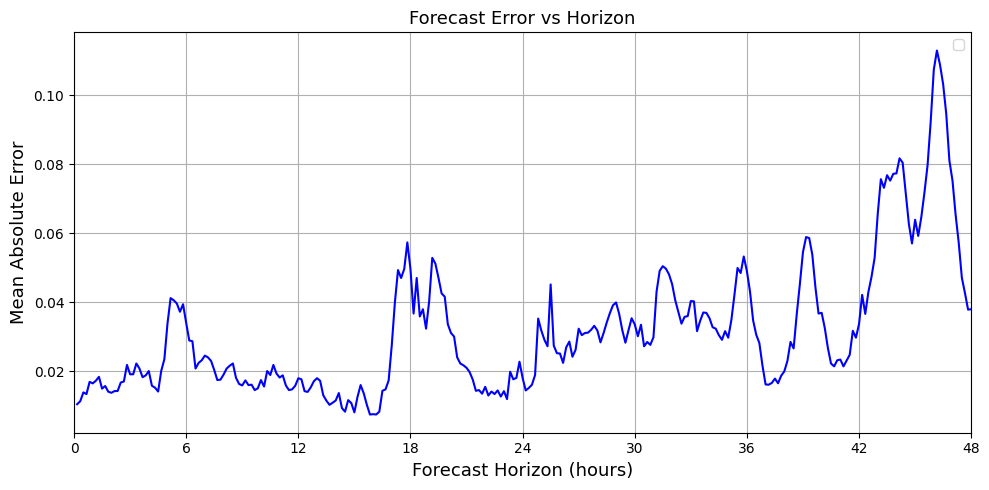

In [12]:
#create a table to visualize the change in error as the horizon progresses
horizons_in_hours = np.arange(1, HORIZON + 1) / 6

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(horizons_in_hours, table['MAE'], color='blue')
ax.set_xticks(np.arange(0,49,6))
ax.set_xlim(left=0, right=48)
plt.xlabel('Forecast Horizon (hours)', fontsize=13)
plt.ylabel('Mean Absolute Error', fontsize=13)
plt.title('Forecast Error vs Horizon', fontsize=13)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('../report/figures/model_summary/horizon_line_plot.pdf')
plt.show()

In [52]:
threshold = 50.0  # example: total rain across all stations > 5mm at t+0

# Compute total precip at each timestep
precip_sums = df_test[[col for col in df_test.columns if col.startswith("precip_")]].sum(axis=1)

# Only use rows that come after a full input window
valid_range = np.arange(HIST_LEN, len(df_test) - HORIZON)

# Filter indices where sum exceeds threshold
valid_idxs = [i - HIST_LEN for i in valid_range if precip_sums.iloc[i] > threshold]

# Choose one at random
start_idx = np.random.choice(valid_idxs)

print(f"Selected start index: {start_idx} (t+0 precip sum = {precip_sums.iloc[start_idx + HIST_LEN]:.2f})")

Selected start index: 10365 (t+0 precip sum = 54.00)


In [53]:
HORIZON=5

# ── STATION NAMES ─────────────────────────────
stations = sorted({col.split('_')[1] for col in precip_cols})

# ── INITIAL WINDOW ────────────────────────────
# Assume you want to forecast from a specific index `start_idx`
start_idx = np.random.choice(valid_idxs)  # you can loop over multiple start points if needed

x_class = test_scaled_class.iloc[start_idx : start_idx + HIST_LEN].values[np.newaxis, :, :]
x_reg   = test_scaled_reg.iloc[start_idx : start_idx + HIST_LEN].values[np.newaxis, :, :]



# ── RECURSIVE FORECAST ───────────────────────
forecasts = []

for step in range(HORIZON):
    rain_probs = classifier.predict(x_class, verbose=0)[0]
    rain_mask = rain_probs > 0.5

    forecast_row = []
    for j in range(len(stations)):
        if rain_mask[j]:
            log_pred = regressor.predict(x_reg, verbose=0)[0][0]
            forecast = np.expm1(log_pred)
        else:
            forecast = 0.0
        forecast_row.append(forecast)

    forecasts.append(forecast_row)

    # Advance window: roll by 1 step and insert predicted precip
    if step < HORIZON - 1:
        # shift left
        next_class = x_class[0, 1:, :].copy()
        next_reg   = x_reg[0, 1:, :].copy()

        # last timestep to modify
        last_class = x_class[0, -1, :].copy()
        last_reg   = x_reg[0, -1, :].copy()

        for j, station in enumerate(stations):
            p_col = f"precip_{station}"
            idx_class = test_scaled_class.columns.get_loc(p_col)
            idx_reg = test_scaled_reg.columns.get_loc(p_col)

            last_class[idx_class] = forecast_row[j]
            last_reg[idx_reg] = forecast_row[j]

        x_class = np.concatenate([next_class, [last_class]])[np.newaxis, :, :]
        x_reg = np.concatenate([next_reg, [last_reg]])[np.newaxis, :, :]

# Extract actual t+0 precipitation
t0_idx = start_idx + HIST_LEN
true_t0 = df_test.loc[df_test.index[t0_idx], [f"precip_{s}" for s in stations]].values

# Build final array
forecast_array = np.vstack([true_t0[np.newaxis, :], np.array(forecasts)])
forecast_df = pd.DataFrame(forecast_array, columns=stations, index=np.arange(0,HORIZON+1))

print(forecast_df)


        BIN       BLA       BRI       EVI       EVO       FIO       FIT  \
0  0.200000  1.300000  0.500000  1.100000  0.800000  1.700000  0.300000   
1  0.652386  0.652386  0.652386  0.652386  0.652386  0.652386  0.652386   
2  0.375152  0.375152  0.375152  0.375152  0.375152  0.375152  0.375152   
3  0.282085  0.282085  0.000000  0.282085  0.000000  0.282085  0.282085   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        GRC       LEU       MAB  ...     VSSAB     VSSAL     VSSFE     VSSIE  \
0  0.900000  1.700000  1.100000  ...  0.400000  1.400000  1.100000  1.800000   
1  0.652386  0.652386  0.652386  ...  0.652386  0.652386  0.652386  0.652386   
2  0.375152  0.375152  0.375152  ...  0.375152  0.375152  0.375152  0.375152   
3  0.000000  0.282085  0.282085  ...  0.000000  0.282085  0.282085  0.282085   
4  0.000000  0.000000  0.000000  ...  0.000000  0.229296  0.000000  0.0000

In [38]:
forecast_array[3]

array([0.        , 0.31295791, 0.        , 0.31295791, 0.        ,
       0.31295791, 0.31295791, 0.        , 0.31295791, 0.31295791,
       0.31295791, 0.31295791, 0.        , 0.31295791, 0.31295791,
       0.        , 0.        , 0.31295791, 0.31295791, 0.31295791,
       0.31295791, 0.31295791, 0.31295791, 0.31295791, 0.31295791,
       0.31295791, 0.31295791, 0.31295791, 0.31295791, 0.        ,
       0.        , 0.31295791, 0.31295791, 0.31295791, 0.31295791,
       0.        , 0.31295791, 0.31295791, 0.        , 0.31295791,
       0.31295791, 0.31295791, 0.31295791, 0.        , 0.        ,
       0.31295791, 0.        , 0.        ])

In [ ]:

# ── INTERPOLATION ─────────────────────────
def ked_interpolation_gstools(known_points, unknown_points):
    x_known, y_known, z_known = known_points[:, 0], known_points[:, 1], known_points[:, 2]
    values = known_points[:, 3]
    x_unknown, y_unknown, z_unknown = unknown_points[:, 0], unknown_points[:, 1], unknown_points[:, 2]

    if np.all(values == 0):
        return np.zeros(len(unknown_points))

    bin_center, gamma = gs.vario_estimate((x_known, y_known), values, bin_edges=np.linspace(0, 100000, 15))
    model = gs.Exponential(dim=2)
    model.fit_variogram(bin_center, gamma)

    ked = gs.krige.ExtDrift(model=model, cond_pos=(x_known, y_known), cond_val=values, ext_drift=z_known)
    predictions, _ = ked((x_unknown, y_unknown), ext_drift=z_unknown, return_var=True)
    return predictions

df_stations = pd.read_csv('../data/clean/valais_stations.csv')

with rasterio.open('../data/clean/valais_elevation.asc') as src:
    elevation_grid = src.read(1)
    transform = src.transform
    bounds = src.bounds
    height, width = elevation_grid.shape
    rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)

    unknown_points = np.column_stack([
        xs.flatten(),
        ys.flatten(),
        elevation_grid.flatten()
    ])

# Interpolate
mask_valid = ~np.isnan(unknown_points[:, 2])

# ── INTERPOLATE PER TIMESTEP ───────────────────
grids_by_time = []

for t in tqdm(forecast_df.index, desc="Interpolating timesteps"):



    # Melt forecast row to match station info
    row = forecast_df.loc[t]
    station_values = row.to_dict()
    df_stations["rain_prob"] = df_stations["station"].map(station_values).fillna(0)

    known_points = df_stations[["east", "north", "altitude", "rain_prob"]].values
    interpolated = np.full(len(unknown_points), np.nan)
    interpolated[mask_valid] = ked_interpolation_gstools(known_points, unknown_points[mask_valid])

    full_grid = interpolated.reshape(elevation_grid.shape)
    grids_by_time.append(full_grid)

grids_by_time

In [59]:
import pandas as pd
import numpy as np
import os
import gstools as gs
from tqdm import tqdm
import rasterio
import matplotlib.pyplot as plt
# ── INTERPOLATION ─────────────────────────
def ked_interpolation_gstools(known_points, unknown_points):
    x_known, y_known, z_known = known_points[:, 0], known_points[:, 1], known_points[:, 2]
    values = known_points[:, 3]
    x_unknown, y_unknown, z_unknown = unknown_points[:, 0], unknown_points[:, 1], unknown_points[:, 2]

    if np.all(values == 0):
        return np.zeros(len(unknown_points))

    bin_center, gamma = gs.vario_estimate((x_known, y_known), values, bin_edges=np.linspace(0, 100000, 15))
    model = gs.Exponential(dim=2)
    model.fit_variogram(bin_center, gamma)

    ked = gs.krige.ExtDrift(model=model, cond_pos=(x_known, y_known), cond_val=values, ext_drift=z_known)
    predictions, _ = ked((x_unknown, y_unknown), ext_drift=z_unknown, return_var=True)
    return predictions

df_stations = pd.read_csv('../data/clean/valais_stations.csv')

# ── LOAD STATION LOCATIONS ───────────────
df_daily = pd.read_csv('../data/clean/daily_data.csv')
stations_kept = df_daily['unique_id'].unique()

df_stations = df_stations[df_stations['station'].isin(stations_kept)]

with rasterio.open('../data/clean/valais_elevation.asc') as src:
    elevation_grid = src.read(1)
    transform = src.transform
    bounds = src.bounds
    height, width = elevation_grid.shape
    rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    xs = np.array(xs)
    ys = np.array(ys)

    unknown_points = np.column_stack([
        xs.flatten(),
        ys.flatten(),
        elevation_grid.flatten()
    ])

# Interpolate
mask_valid = ~np.isnan(unknown_points[:, 2])

grids_by_time = []

for t in tqdm(forecast_df.index, desc="Interpolating timesteps"):
    df_stations["rain_amount"] = forecast_array[t].flatten()
    known_points = df_stations[["east", "north", "altitude", "rain_amount"]].values

    interpolated_values = np.full(len(unknown_points), np.nan)
    interpolated_values[mask_valid] = ked_interpolation_gstools(known_points, unknown_points[mask_valid])
    full_grid = interpolated_values.reshape(elevation_grid.shape)
    full_grid = np.clip(full_grid, 0, None)
    print(full_grid)
    grids_by_time.append(full_grid)

grids_by_time = np.array(grids_by_time)

Interpolating timesteps:  17%|█▋        | 1/6 [00:00<00:01,  4.33it/s]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


Interpolating timesteps:  33%|███▎      | 2/6 [00:00<00:00,  4.14it/s]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


Interpolating timesteps:  50%|█████     | 3/6 [00:00<00:00,  4.09it/s]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


Interpolating timesteps:  67%|██████▋   | 4/6 [00:00<00:00,  4.15it/s]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


Interpolating timesteps:  83%|████████▎ | 5/6 [00:01<00:00,  4.25it/s]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


Interpolating timesteps: 100%|██████████| 6/6 [00:01<00:00,  4.05it/s]

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [55]:
grids_by_time

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ..

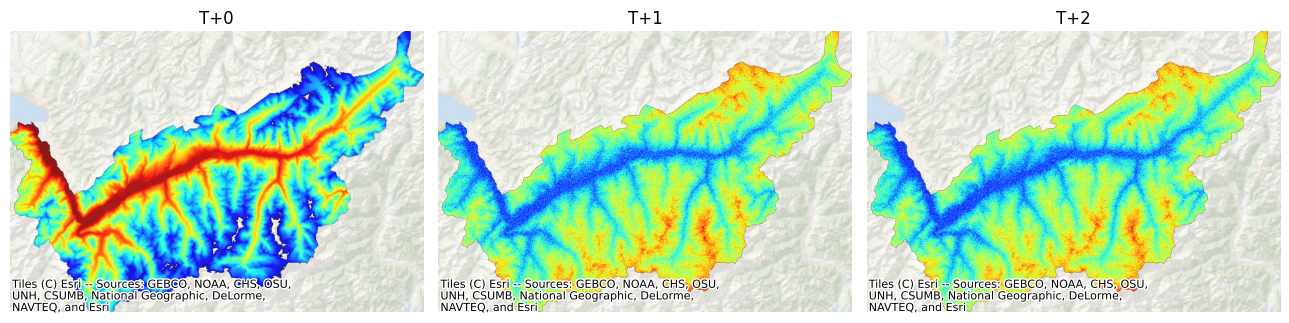

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import contextily as cx
import xyzservices.providers as xyz
import numpy.ma as ma

fig, axes = plt.subplots(1, 3, figsize=(13, 10))
axes = axes.flatten()

for i in range(len(axes)):
    grid_masked = ma.masked_less(grids_by_time[i], 0.1)

    ax = axes[i]
    img = ax.imshow(
        grid_masked,
        cmap='jet',  
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
        origin='upper',
        alpha=0.9,
        zorder=3,
    )

    # Add basemap
    cx.add_basemap(ax, source=xyz.Esri.OceanBasemap, crs="EPSG:2056")

    ax.set_title(f"T+{i}", fontsize=12)
    ax.set_axis_off()

plt.tight_layout()
plt.show()
